# Data Loader


In [1]:
import pandas as pd
import os
import random
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchaudio import transforms
from torch.utils.data import Dataset, random_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from pathlib import Path

pd.set_option('display.max_rows', None)

download_path = Path.cwd()/'metadata'/'cnt_Philippinesgrp_birds'
data_path = Path.cwd()

df = pd.DataFrame()
for file in os.listdir(download_path):
    if 'csv' in file:
        filepath = os.path.join(download_path, file)
        if df.empty:
            df = pd.read_csv(filepath)
        else:
            temp_df = pd.read_csv(filepath)
            df = pd.concat([df, temp_df])
    
df['recordings__en'] = df['recordings__en'].apply(lambda x: x.replace(' ', ''))
df['relative_path'] = '/audio' + '/' + df['recordings__en'].astype(str) + '/' + df['recordings__id'].astype(str) + '.mp3'

df2 = df
df['relative_path'] = '/newaudio' + '/' + df['recordings__id'].astype(str) + '.wav'
df = pd.concat([df, df2],ignore_index=True)
df = pd.concat([df, df],ignore_index=True)

df = df[['recordings__en', 'relative_path', 'recordings__file-name']]

# Pick Only 10 for Labels
# PhilippineBulbul 60
# Balicassiao 59
# White-earedBrownDove 57
# LuzonHawk-Owl 51
# PhilippineCoucal 45
# White-browedShortwing 43
# ElegantTit 42
# Long-tailedBushWarbler 42
# White-ventedWhistler 38
# Grey-backedTailorbird 36

df = df[df['recordings__en'].isin(['PhilippineBulbul', 'Balicassiao', 'White-earedBrownDove', 'LuzonHawk-Owl', 'PhilippineCoucal', 'White-browedShortwing', 'ElegantTit',
                        'Long-tailedBushWarbler', 'White-ventedWhistler', 'Grey-backedTailorbird'])]

#Clean the Data
labels = df['recordings__en']
labels_unique = set(labels)
keys = {key: value for key, value in zip(labels_unique, range(len(labels_unique)))}

df2 = pd.Series(keys).to_frame('labels')
print(len(df2['labels']))
df2 = pd.DataFrame(df2).reset_index()
df2.columns = ['recordings__en', 'labels']

print(df2.drop_duplicates())

df = pd.merge(df, df2, on="recordings__en")

df = df.dropna()
df = df.drop('recordings__file-name', axis=1)
df = df.drop('recordings__en', axis=1)

df.reset_index(inplace = True)
#df.to_csv('birds(new).csv')

print('\nRow Count:', df.shape[0])    


10
           recordings__en  labels
0        PhilippineBulbul       0
1   White-browedShortwing       1
2        PhilippineCoucal       2
3  Long-tailedBushWarbler       3
4           LuzonHawk-Owl       4
5    White-earedBrownDove       5
6    White-ventedWhistler       6
7             Balicassiao       7
8              ElegantTit       8
9   Grey-backedTailorbird       9

Row Count: 1892


In [2]:
class AudioUtil():
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)

  #Normalize the Audio Data
  @staticmethod
  def rechannel(aud, new_channel):
      sig, sr = aud

      if (sig.shape[0] == new_channel):
        # Nothing to do
        return aud

      if (new_channel == 1):
        # Convert from stereo to mono by selecting only the first channel
        resig = sig[:1, :]
      else:
        # Convert from mono to stereo by duplicating the first channel
        resig = torch.cat([sig, sig])

      return ((resig, sr))

  @staticmethod
  def resample(aud, newsr):
      sig, sr = aud

      if (sr == newsr):
        # Nothing to do
        return aud

      num_channels = sig.shape[0]
      # Resample first channel
      resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
      if (num_channels > 1):
        # Resample the second channel and merge both channels
        retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
        resig = torch.cat([resig, retwo])

      return ((resig, newsr))

  #Apply Time Shift for Data Augmentation
  @staticmethod
  def time_shift(aud, shift_limit):
      sig,sr = aud
      _, sig_len = sig.shape
      shift_amt = int(random.random() * shift_limit * sig_len)
      return (sig.roll(shift_amt), sr)

  #Apply Mel-Spectrogram
  @staticmethod
  def spectro_gram(aud, class_id, n_mels=64, n_fft=1024, hop_len=None):
      sig,sr = aud
      top_db = 80

      # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
      #scale = nr.reduce_noise(y=sig, sr=44100)
      spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

      # Convert to decibels
      spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
      # plot_spectrogram(spec[0], title=class_id, ylabel="mel freq")
      return (spec)

  #Apply Time and Frequency Masking
  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
      _, n_mels, n_steps = spec.shape
      mask_value = spec.mean()
      aug_spec = spec

      freq_mask_param = max_mask_pct * n_mels
      for _ in range(n_freq_masks):
        aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

      time_mask_param = max_mask_pct * n_steps
      for _ in range(n_time_masks):
        aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

      return aug_spec
  
  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

In [3]:
class SoundDS(Dataset):
  def __init__(self, df, data_path):
    self.df = df
    self.data_path = str(data_path)
    self.duration = 4000
    self.sr = 44100
    self.channel = 1
    self.shift_pct = 0.4

  # Number of items in dataset
  def __len__(self):
    return len(self.df)    
    
  # Get i'th item in dataset
  def __getitem__(self, idx):
    audio_file = self.data_path + self.df.loc[idx, 'relative_path']
    class_id = self.df.loc[idx, 'labels']

    aud = AudioUtil.open(audio_file)
    # Some sounds have a higher sample rate, or fewer channels compared to the
    # majority. So make all sounds have the same number of channels and same 
    # sample rate. Unless the sample rate is the same, the pad_trunc will still
    # result in arrays of different lengths, even though the sound duration is
    # the same.
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel)

    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, class_id, n_mels=64, n_fft=1024, hop_len=None)
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return aug_sgram, class_id

In [4]:
myds = SoundDS(df, data_path)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

In [5]:
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init

# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super(AudioClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 256, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.pooling = nn.AdaptiveAvgPool2d((8, 8)) # extended
        self.fc1 = nn.Linear(16384, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = self.pooling(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x
    
# Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cuda', index=0)

In [6]:
# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  epoch_nums = []
  training_loss = []
  validation_loss = []
  training_acc = []
  validation_acc = []

  # Repeat for each epoch
  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        #Training Data
        # Get the input features and target labels, and put them on the GPU
        print(data[1].to(device))
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        #if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))

        #Testing Data
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
      batch_count = 0
      for data, target in val_dl:
        batch_count += 1
        data, target = data.to(device), target.to(device)
                
        # Get the predicted classes for this batch
        output = model(data)
                
        # Calculate the loss for this batch
        test_loss += criterion(output, target).item()
                
        # Calculate the accuracy for this batch
        _, predicted = torch.max(output.data, 1)
        correct += torch.sum(target==predicted).item()
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    val_loss = test_loss / batch_count
    acc = correct_prediction/total_prediction
    
    epoch_nums.append(epoch)
    training_loss.append(avg_loss)
    validation_loss.append(val_loss)
    training_acc.append(acc)
    validation_acc.append(correct/len(val_dl.dataset))

    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_dl.dataset),
        100. * correct / len(val_dl.dataset)))

  print('Finished Training')
  return epoch_nums, training_loss, validation_loss, training_acc, validation_acc
  
num_epochs=50   # Just for demo, adjust this higher.
epoch_nums, training_loss, validation_loss, training_acc, validation_acc = training(myModel, train_dl, num_epochs)

tensor([5, 7, 0, 7, 8, 4, 1, 2, 0, 4, 1, 6, 5, 4, 4, 1], device='cuda:0')
tensor([1, 8, 5, 4, 7, 0, 0, 5, 6, 2, 7, 4, 2, 7, 6, 5], device='cuda:0')
tensor([5, 1, 5, 0, 6, 3, 7, 5, 2, 6, 9, 0, 1, 4, 3, 5], device='cuda:0')
tensor([9, 7, 4, 1, 3, 8, 2, 2, 4, 9, 0, 0, 7, 1, 7, 0], device='cuda:0')
tensor([4, 2, 6, 0, 6, 6, 4, 0, 1, 1, 3, 0, 1, 0, 8, 5], device='cuda:0')
tensor([0, 9, 1, 4, 4, 8, 5, 8, 0, 7, 2, 2, 3, 5, 4, 9], device='cuda:0')
tensor([4, 8, 5, 3, 8, 1, 6, 0, 6, 5, 4, 9, 8, 0, 9, 8], device='cuda:0')
tensor([4, 7, 8, 5, 4, 5, 9, 4, 5, 7, 0, 1, 2, 8, 6, 9], device='cuda:0')
tensor([1, 2, 8, 0, 3, 5, 4, 7, 8, 6, 0, 6, 6, 1, 2, 8], device='cuda:0')
tensor([2, 0, 1, 9, 4, 2, 7, 5, 5, 6, 0, 0, 0, 4, 8, 5], device='cuda:0')
tensor([5, 4, 8, 5, 2, 0, 7, 4, 5, 0, 5, 2, 2, 3, 1, 3], device='cuda:0')
tensor([7, 5, 1, 4, 8, 5, 1, 3, 7, 8, 5, 7, 2, 7, 7, 0], device='cuda:0')
tensor([9, 8, 5, 3, 5, 2, 8, 4, 2, 7, 9, 0, 2, 0, 4, 5], device='cuda:0')
tensor([3, 1, 4, 4, 7, 4, 6, 9, 1, 4, 

In [7]:
'''
import pytorch_lightning as pl
from torchmetrics.functional import accuracy

class myModel(pl.LightningModule):

    def __init__(self, model, learning_rate=3e-4):

        super().__init__()
        self.learning_rate = learning_rate
        self.model = model

    def forward(self, x):
        x = self.model(x)
        x = F.log_softmax(x, dim=1)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx, split='val'):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=10)

        self.log(f'{split}_loss', loss, prog_bar=True)
        self.log(f'{split}_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def train_dataloader(self):
        return train_dl

    def val_dataloader(self):
        return val_dl

learner = myModel(AudioClassifier())
checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_acc')
trainer = pl.Trainer(devices="auto", max_epochs=100, callbacks=[checkpoint], accelerator="gpu")
trainer.fit(learner)
'''

'\nimport pytorch_lightning as pl\nfrom torchmetrics.functional import accuracy\n\nclass myModel(pl.LightningModule):\n\n    def __init__(self, model, learning_rate=3e-4):\n\n        super().__init__()\n        self.learning_rate = learning_rate\n        self.model = model\n\n    def forward(self, x):\n        x = self.model(x)\n        x = F.log_softmax(x, dim=1)\n        return x\n\n    def training_step(self, batch, batch_idx):\n        x, y = batch\n        logits = self(x)\n        loss = F.nll_loss(logits, y)\n        return loss\n\n    def validation_step(self, batch, batch_idx, split=\'val\'):\n        x, y = batch\n        logits = self(x)\n        loss = F.nll_loss(logits, y)\n        preds = torch.argmax(logits, dim=1)\n        acc = accuracy(preds, y, task="multiclass", num_classes=10)\n\n        self.log(f\'{split}_loss\', loss, prog_bar=True)\n        self.log(f\'{split}_acc\', acc, prog_bar=True)\n        return loss\n\n    def configure_optimizers(self):\n        optimi

In [8]:
'''
# ----------------------------
# Inference
# ----------------------------
device = torch.device("cuda")

def eval_acc(model, device, dataloader, debug_name=None):
    model = model.to(device).eval()
    count = correct = 0
    for X, gt in dataloader:
        logits = model(X.to(device))
        preds = torch.argmax(logits, dim=1)
        correct += sum(preds.cpu() == gt)
        count += len(gt)
    acc = correct/count
    if debug_name:
        print(f'{debug_name} acc = {acc:.4f}')
    return acc

learner.load_state_dict(torch.load(checkpoint.best_model_path)['state_dict'])
eval_acc(learner.model, device, learner.val_dataloader(), 'val')
'''

'\n# ----------------------------\n# Inference\n# ----------------------------\ndevice = torch.device("cuda")\n\ndef eval_acc(model, device, dataloader, debug_name=None):\n    model = model.to(device).eval()\n    count = correct = 0\n    for X, gt in dataloader:\n        logits = model(X.to(device))\n        preds = torch.argmax(logits, dim=1)\n        correct += sum(preds.cpu() == gt)\n        count += len(gt)\n    acc = correct/count\n    if debug_name:\n        print(f\'{debug_name} acc = {acc:.4f}\')\n    return acc\n\nlearner.load_state_dict(torch.load(checkpoint.best_model_path)[\'state_dict\'])\neval_acc(learner.model, device, learner.val_dataloader(), \'val\')\n'

Accuracy: 0.90, Total items: 378
[4.003731985886891, 12.005036433537802, 2.9333742509285607, 19.905481616655987, 3.3134892135858536, 3.5214412162701287, 5.077887068192164, 5.154216845830281, 3.7933730681737265, 4.827668209870656, 12.659902274608612, 6.208194365104039, 5.074207993845145, 6.017630686362584, 5.895779381195704, 5.527238483230273, 4.706326946616173, 8.85562895735105, 5.739310423533122, 7.084109346071879, 6.478382738928, 5.172266254822413, 7.827311118443807, 7.998215809464455, 6.905571356415749, 5.579242209593455, 4.7566519901156425, 5.860903223355611, 7.299101193745931, 6.934119661649068, 6.535757794976234, 7.094149028261502, 9.084530785679817, 7.34773261534671, 6.634840925534566, 6.542175312836965, 7.622319941719373, 8.188141584396362, 8.09795331954956, 7.915188347299893, 9.374990890423456, 8.792394095410904, 7.955621396501859, 10.750539441903433, 9.053045734763145, 9.28609000146389, 10.4587731162707, 10.387711519996325, 10.805097406109175, 9.199677089850107]


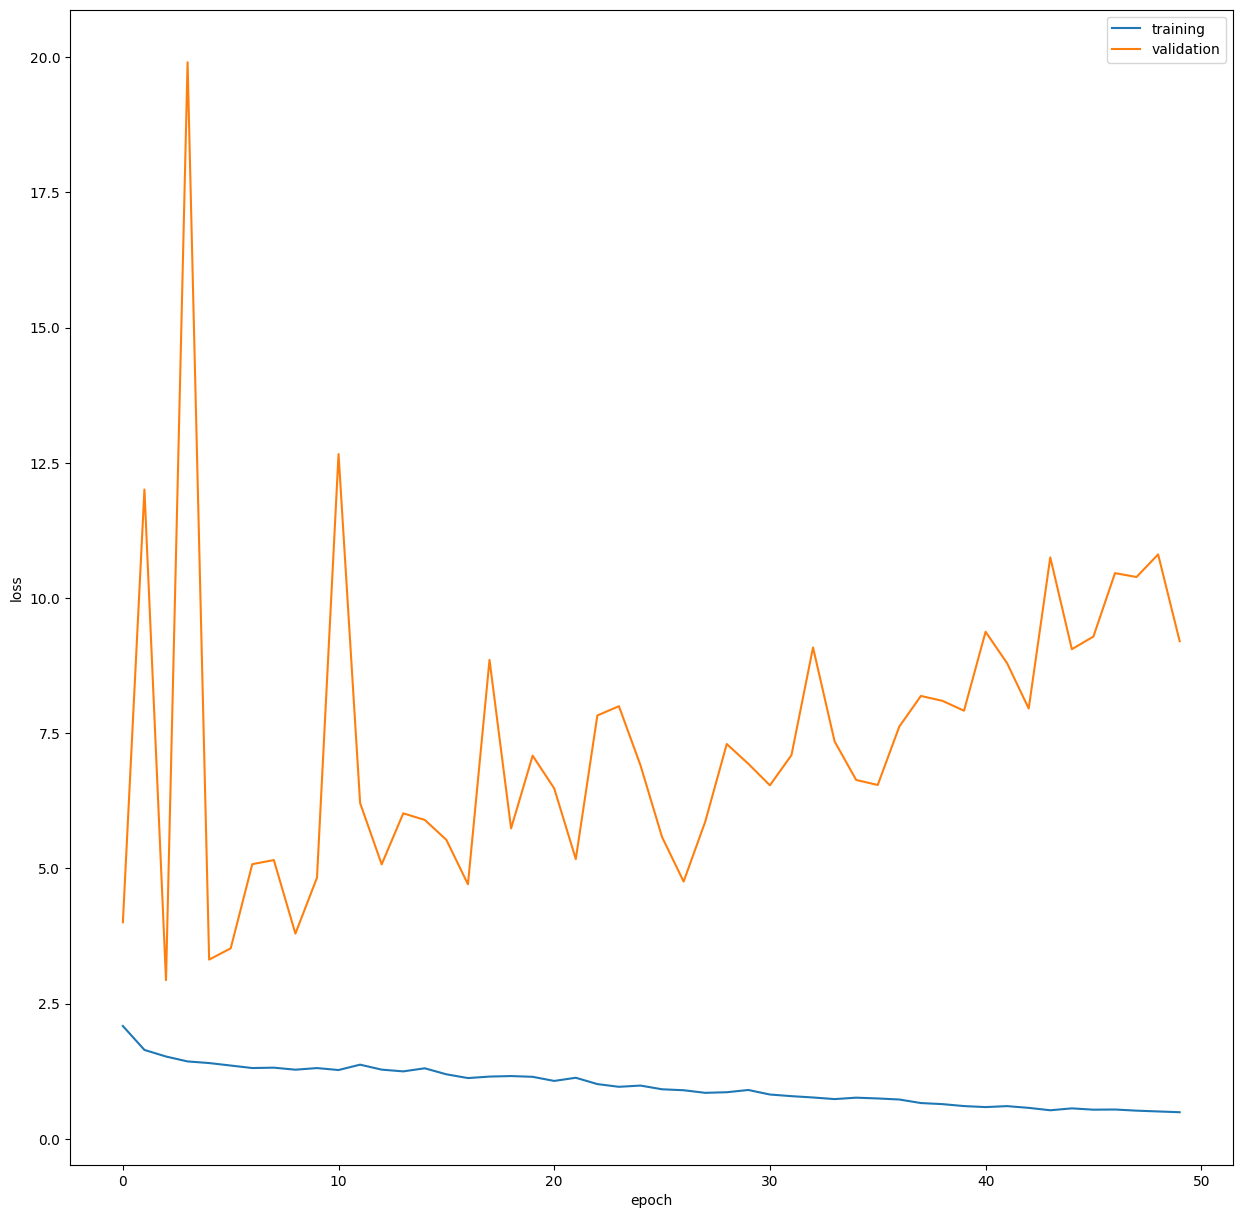

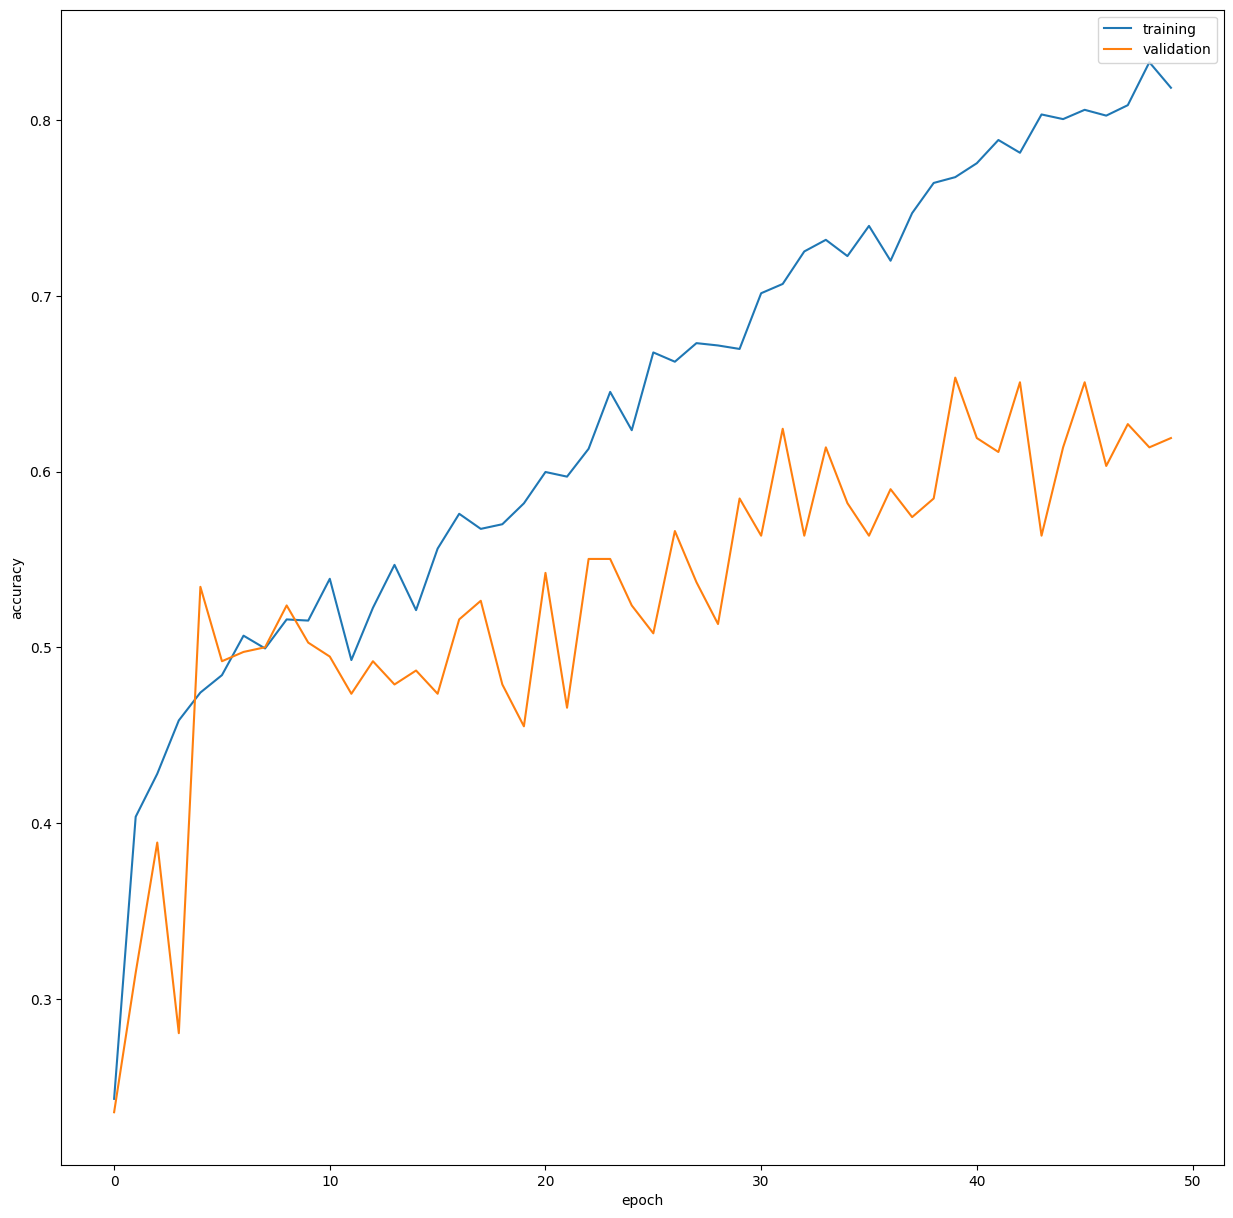

Getting predictions from test set...
[[23  2  1  0  1  3  6  2  2  3]
 [ 0 33  0  1  0  1  2  0  3  2]
 [ 0  2  9  3  1 14  0  0  0  0]
 [ 0  0  1 29  0  0  0  0  0  0]
 [ 0  2  0  0 30  1  0  0  0  1]
 [ 1  1  2  5  4 29  0  0  3  1]
 [ 2  5  1  1  0  3 15  0  2  1]
 [ 2 13  1  5  1  0  8 17  5  5]
 [ 0  6  1  6  1  1  0  0 11  0]
 [ 0  4  0  0  2  4  0  0  0 31]]


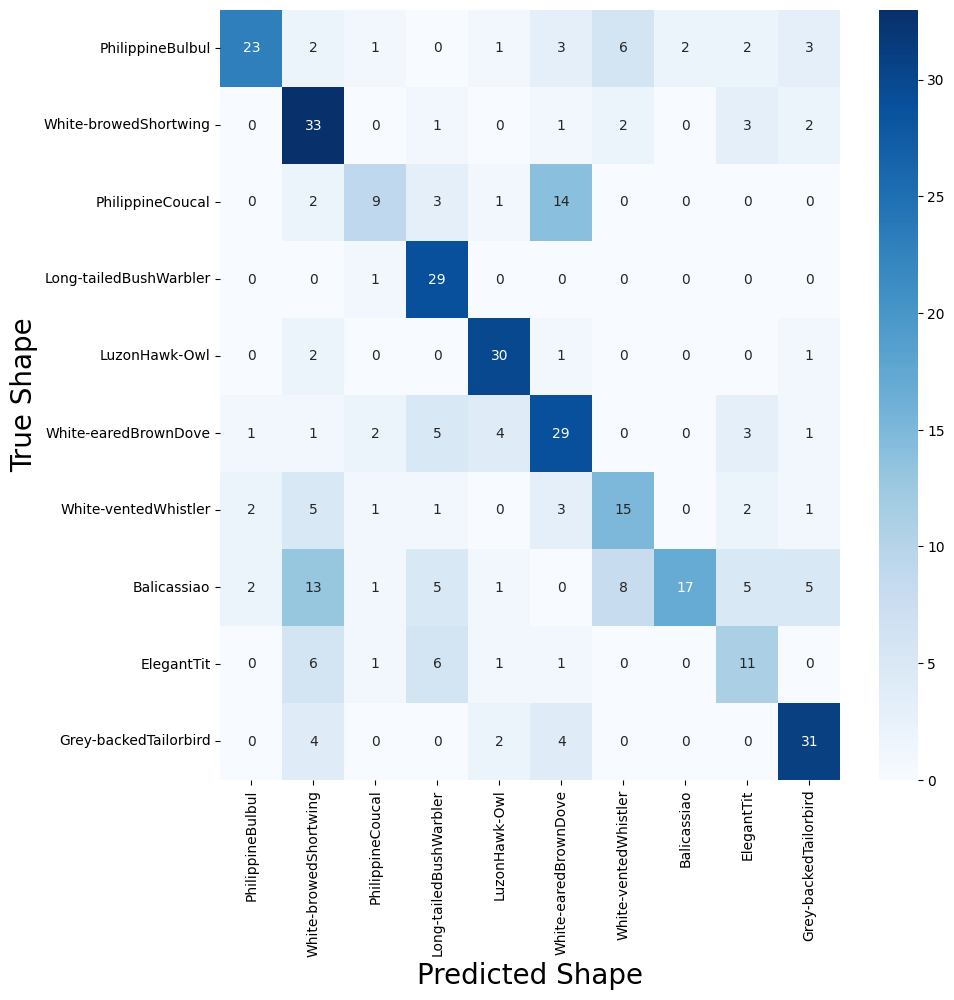

In [9]:
def inference (model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

# Run inference on trained model with the validation set
inference(myModel, val_dl)

print(validation_loss)
# Show Plots
plt.figure(figsize=(15,15))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

plt.figure(figsize=(15,15))
plt.plot(epoch_nums, training_acc)
plt.plot(epoch_nums, validation_acc)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

#Evaluate Model
truelabels = []
predictions = []
myModel.eval()
myModel.to(device)
print("Getting predictions from test set...")
for data, target in val_dl:
    data = data.cuda()
    for label in target.data.numpy():
        truelabels.append(label)
    for prediction in myModel(data).cpu().data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
tick_marks = np.arange(len(labels))
print(cm)
df_cm = pd.DataFrame(cm, index = list(labels_unique), columns = list(labels_unique))
plt.figure(figsize = (10,10))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Shape", fontsize = 20)
plt.ylabel("True Shape", fontsize = 20)
plt.show()